In [1]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List
from qiskit import QuantumCircuit

def encode_qiskit(image):
    desired_state = np.zeros(1024)
    for i in range(len(sample_img)):
        desired_state[i] = sample_img[i]
    nrm = np.linalg.norm(desired_state)
    desired_state = desired_state/nrm
    qc = QuantumCircuit(10)
    qc.initialize(desired_state, [i for i in range(10)])
    #qc.decompose().decompose().decompose().decompose().decompose().draw()
    return qc

In [5]:
import matplotlib.pyplot as plt

#define utility functions

#this simulate a circuit (without measurement) and output results in the format of histogram.
def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive

def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    return Counter([len(gate[1]) for gate in circuit.data])

def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)
#load the actual hackthon data (fashion-mnist)
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')

In [6]:
sample_img = np.matrix(images[10])
def downsizing(sample_img):
    test_img = np.zeros((3,5))
    col_break_pt = [5,11,17,23,28]
    row_break_pt = [9,18,28]
    for i in range(3):
        for j in range(5):
            if j==0:
                test_img[i,j] = round(np.mean(sample_img[9*i:row_break_pt[i],:col_break_pt[j]]),4)
            else:
                test_img[i,j] = round(np.mean(sample_img[9*i:row_break_pt[i],col_break_pt[j-1]:col_break_pt[j]]),4)
    return test_img

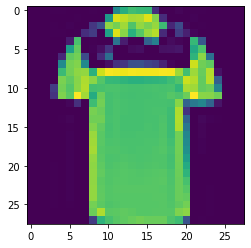

In [7]:
plt.imshow(sample_img)

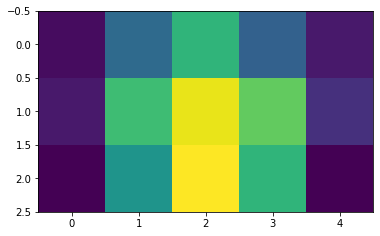

In [8]:
test_img = downsizing(sample_img)
plt.imshow(test_img)

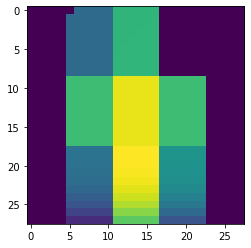

In [9]:
def reconstruction(test_img):
    img = np.zeros((28,28))
    min_img = 1e-4
    for i in range(9):
        for j in range(5):
            img[8-i,4-j] = abs(round(test_img[0,0] - j**3*1e-5 - 3*i*1e-6 - 2*min_img,2))

    for i in range(9):
        for j in range(5):
            img[8-i,23+j] = abs(round(test_img[0,4]-2*min_img -j**3*1e-5 -i*3*1e-6,2))



    for k in range(3):
        for i in range(9):
            for j in range(6):
                img[i,5+k*6 +j]= round(test_img[0,k+1]-5*(abs(k-1))*min_img+j*1e-6  +i*1e-6,5-2*abs(k-1))

    for i in range(9):
        for j in range(5):
            img[17-i,4-j] = abs(round(test_img[1,0] - j**3*1e-5 - 2*min_img,2))
    for i in range(9):
        for j in range(5):
            img[17-i,23+j] = abs(round(test_img[1,4]-2*min_img -j**3*1e-5 ,2))
    for k in range(3):
        for i in range(9):
            for j in range(6):
                img[9+i,5+k*6 +j]= round(test_img[1,k+1]-5*(abs(k-1))*min_img,5-2*abs(k-1))

    for i in range(10):
        for j in range(5):
            img[18+i,5-j] = abs(round(test_img[2,0] - j**3*1e-5 -i**3*1e-6  - 2*min_img,2))
    for i in range(10):
        for j in range(5):
            img[18+i,27-j] = abs(round(test_img[2,4]-2*min_img-i**3*1e-6  -j**3*1e-5 ,2))
    for k in range(3):
        for i in range(10):
            for j in range(6):
                img[18+i,5+k*6 +j]= round(test_img[2,k+1]-4*(abs(k-1))*min_img-i**3*1e-6 ,5)
    return img
plt.imshow(reconstruction(test_img))

In [10]:
np.linalg.norm(reconstruction(test_img)-sample_img)

0.030961453423940702

In [ ]:
def decode(histogram): 
    n=15
    options = {}
    hist_keys = list(histogram.keys())
    for i in range(n):
        options[i]=0
    for i in range(len(histogram)):
        for j in range(i,len(histogram)):
            x = hist_keys[i]^hist_keys[j]
            if x and (not(x & (x-1))):
                val1 = bin(hist_keys[i])[2:].zfill(n)
                val2 = bin(hist_keys[j])[2:].zfill(n)
                for k in range(n):
                    if val1[k]!=val2[k]:
                        if options[n-1-k] ==0:                            
                            options[n-1-k] = 2*np.arctan(np.sqrt(histogram[hist_keys[j]]/histogram[hist_keys[i]]))
            else:
                continue
    image = []
    for i in range(n):
        image.append(round(options[i]/10,4))
    return reconstruction(np.asarray(image).reshape((3,5)))


In [50]:
def encode_qiskit(image):
    img_arr = np.asarray(downsizing(image)).reshape(-1)
    desired_state = img_arr
    q = qiskit.QuantumRegister(len(desired_state))
    circuit = qiskit.QuantumCircuit(q)
    i=0
    for ele in desired_state:
        if ele>1e-8:
            circuit.rx(10*ele,i)
        i+=1
    circuit.decompose().draw()
    return circuit

In [52]:
J = sample_img
encode_qiskit(J).draw()

┌───────────┐
 q4882_0: ┤ Rx(0.001) ├
          └┬──────────┤
 q4882_1: ─┤ Rx(0.01) ├
          ┌┴──────────┤
 q4882_2: ┤ Rx(0.019) ├
          ├───────────┤
 q4882_3: ┤ Rx(0.009) ├
          ├───────────┤
 q4882_4: ┤ Rx(0.002) ├
          ├───────────┤
 q4882_5: ┤ Rx(0.002) ├
          └┬──────────┤
 q4882_6: ─┤ Rx(0.02) ├
          ┌┴──────────┤
 q4882_7: ┤ Rx(0.028) ├
          ├───────────┤
 q4882_8: ┤ Rx(0.022) ├
          ├───────────┤
 q4882_9: ┤ Rx(0.004) ├
          └───────────┘
q4882_10: ─────────────
          ┌───────────┐
q4882_11: ┤ Rx(0.015) ├
          ├───────────┤
q4882_12: ┤ Rx(0.029) ├
          ├───────────┤
q4882_13: ┤ Rx(0.019) ├
          └───────────┘
q4882_14: ─────────────

In [55]:
circuit=encode_qiskit(J)

#simulate circuit
histogram=simulate(circuit)

In [56]:

n = len(images)
mse=0
gatecount=0

for image in images:
    #encode image into circuit
    #J = downsizing(image)
    circuit=encode_qiskit(image)

    #simulate circuit
    histogram=simulate(circuit)

    #count the number of 2-qubit gates
    gatecount+=count_gates(circuit)[2]
    #print(gatecount)

    #reconstruct the image
    image_re=decode(histogram)
    #image_rec = reconstruction(downsizing(image))
    #calculate mse
    mse+=image_mse(np.asarray(image),image_re)
#fidelity of reconstruction
f=1-mse
gatecount=gatecount/n

#score for part1
print(f*(0.999**gatecount))



0.9980524629123861


In [ ]:
#grade part 2

#load classifier circuit
classifier=qiskit.QuantumCircuit.from_qasm_file('part2.qasm')
    
score=0

for data in dataset:
    #encode image into circuit
    circuit=encode_qiskit(data['image'])
    
    nq1 = circuit.width()
    nq2 = classifier.width()
    nq = max(nq1, nq2)
    qc = qiskit.QuantumCircuit(nq)
    qc.append(circuit.to_instruction(), list(range(nq1)))
    qc.append(classifier.to_instruction(), list(range(nq2)))

    gatecount+=count_gates(qc)[2]
    
    #simulate circuit
    histogram=simulate(qc)
    
    #convert histogram to category
    cat=histogram_to_category(histogram)
    
    
    if cat==data['category']:
        score+=1
#score
score=score/n
gatecount=gatecount/n

print(score*(0.999**gatecount))

In [36]:
1^3

2